Install Julia if running on Google Colab

In [ ]:
%%capture
%%shell
wget -O - https://raw.githubusercontent.com/JuliaAI/Imbalance.jl/dev/docs/src/examples/colab.sh
"""
This should take around one minute to finish. Once it does, change the runtime to `Julia` by choosing `Runtime` 
from the toolbar then `Change runtime type`. You can then delete this cell.
"""

Install needed packages

In [ ]:
ENV["JULIA_PKG_SERVER"] = ""
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add(["DataFrames", "Plots", "Colors", "CategoricalArrays", "Random", 
         "Imbalance", "MLJBase", "TableTransforms", "ScientificTypes", "HTTP"])
         
using DataFrames
using Plots
using CategoricalArrays
using Random
using Imbalance
using MLJBase: machine, transform
using TableTransforms
using HTTP: download

### 1. Generate Random Data

In [154]:
rng = Random.default_rng()

type = "ColTable"
num_rows = 200
num_features = 5

class_probs = [0.2, 0.4, 0.4]
y_ind = 3

Xy, _ = generate_imbalanced_data(
	num_rows,
	num_features;
	min_sep = 0.2,
	stds=[0.5 0.3 0.3],
	class_probs,
	type,
	insert_y = y_ind,
	rng = 42,
)
X, y = generate_imbalanced_data(num_rows, num_features; min_sep=0.5, stds=[0.1 0.05 0.05], class_probs, type, rng = 4)


((Column1 = [0.301, 0.711, 0.856, 0.85, 0.324, 0.343, 0.315, 0.343, 0.842, 0.591  …  0.915, 0.414, 0.366, 0.659, 0.338, 0.897, 0.871, 0.343, 0.334, 0.236], Column2 = [1.017, 0.317, 0.301, 0.274, 0.984, 1.018, 0.922, 0.931, 0.339, 0.803  …  0.288, 0.908, 0.998, 0.712, 0.931, 0.32, 0.208, 1.041, 0.95, 0.977], Column3 = [0.31, 0.681, 0.747, 0.815, 0.394, 0.429, 0.308, 0.31, 0.698, 0.875  …  0.696, 0.295, 0.327, 0.88, 0.3, 0.76, 0.729, 0.419, 0.286, 0.413], Column4 = [0.33, 0.721, 0.68, 0.711, 0.264, 0.31, 0.287, 0.302, 0.71, 0.764  …  0.57, 0.309, 0.308, 0.851, 0.152, 0.675, 0.71, 0.295, 0.276, 0.267], Column5 = [0.348, 0.744, 0.632, 0.745, 0.387, 0.369, 0.32, 0.307, 0.767, 0.23  …  0.769, 0.418, 0.363, 0.261, 0.263, 0.777, 0.729, 0.328, 0.411, 0.322]), CategoricalValue{Int64, UInt32}[2, 1, 1, 1, 2, 2, 2, 2, 1, 0  …  1, 2, 2, 0, 2, 1, 1, 2, 2, 2])

### 2. Apply ROSE

#### Using Imbalance Only

In [155]:
Xover, yover = rose(X, y; s = 0.3, ratios = Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng = 42)

((Column1 = [0.301, 0.711, 0.856, 0.85, 0.324, 0.343, 0.315, 0.343, 0.842, 0.591  …  0.5372236957699962, 0.6704577316365085, 0.6174345539936548, 0.6437763806299455, 0.6360355449761498, 0.48095766077524926, 0.6188787484006528, 0.601745150836377, 0.47731900463644067, 0.4767187418209852], Column2 = [1.017, 0.317, 0.301, 0.274, 0.984, 1.018, 0.922, 0.931, 0.339, 0.803  …  0.6250819184304119, 0.6708819567809494, 0.8343996384016148, 0.9043559835990157, 0.7509799424915578, 0.5280145505050398, 0.838385555284696, 0.8517136297584067, 0.5245394274934466, 0.7332861453305024], Column3 = [0.31, 0.681, 0.747, 0.815, 0.394, 0.429, 0.308, 0.31, 0.698, 0.875  …  0.7734203547449531, 0.8077458474092736, 0.9703232873281363, 0.9320903022328427, 0.9902542443533296, 0.7910232104066025, 0.9568624526357963, 0.8864214845641779, 0.8014856130080261, 0.7553342823585947], Column4 = [0.33, 0.721, 0.68, 0.711, 0.264, 0.31, 0.287, 0.302, 0.71, 0.764  …  0.8485357639659024, 0.8508320593749803, 1.0580595673785422, 1.0664

#### Using MLJ

In [156]:
rose_model = Imbalance.MLJ.ROSE(s=0.09, ratios=Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng=42)
mach = machine(rose_model)
Xover, yover = transform(mach, X, y)

((Column1 = [0.301, 0.711, 0.856, 0.85, 0.324, 0.343, 0.315, 0.343, 0.842, 0.591  …  0.5398671087309989, 0.6652373194909526, 0.6087303661980964, 0.6383329141889836, 0.647210663492845, 0.4795872982325748, 0.6091636245201958, 0.594223545250913, 0.47849570139093217, 0.4608156225462956], Column2 = [1.017, 0.317, 0.301, 0.274, 0.984, 1.018, 0.922, 0.931, 0.339, 0.803  …  0.5984245755291235, 0.6639645870342848, 0.8425198915204845, 0.8901067950797047, 0.7502939827474673, 0.533604365151512, 0.8437156665854088, 0.8176140889275221, 0.532561828248034, 0.7022858435991507], Column3 = [0.31, 0.681, 0.747, 0.815, 0.394, 0.429, 0.308, 0.31, 0.698, 0.875  …  0.7787261064234859, 0.8072237542227821, 0.9504969861984408, 0.9236270906698528, 0.9907762733059989, 0.7791069631219808, 0.9464587357907388, 0.8784264453692534, 0.7822456839024078, 0.7299002847075784], Column4 = [0.33, 0.721, 0.68, 0.711, 0.264, 0.31, 0.287, 0.302, 0.71, 0.764  …  0.8600607291897707, 0.8348496178124941, 1.0594178702135628, 1.0864200

#### Using TableTransforms

In [157]:
using Imbalance: TableTransforms.ROSE
rose_model_t = ROSE(y_ind, ratios=Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng=42)
apply(rose_model_t, Xy)

((Column1 = [0.726, 0.929, 0.368, 0.614, 0.752, 0.749, 0.786, 0.802, -0.605, 1.012  …  0.08771652968013247, -0.5591411396888493, -0.30450090388742684, 0.45958845109638385, 0.3019626516779732, -0.2846866251378176, -0.27178120013304813, -0.09629928726337286, -0.14805462978428194, 0.7866439292463487], Column2 = [-0.214, 0.809, 1.16, 0.848, 1.209, 0.499, 1.064, 0.75, 0.965, -0.011  …  0.8531681441168708, 1.2958994509718251, 0.8804595571177023, 0.8139351194999511, 1.4011223539813356, 0.8464279816658559, -0.005593497854144341, 0.6299747492494481, 0.9633550156457339, 0.39030890784647365], Column3 = [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], Column4 = [0.064, -0.372, 0.519, 0.62, 0.626, 0.474, 0.02, -0.289, 0.337, 0.323  …  0.3077924112199754, -0.21204644681420115, 0.13940552612139356, 0.2456911351827936, -0.06186877874508407, 0.44521778593534306, -0.04945065645723174, 0.22754907708955424, 0.5007349997290218, 0.6687238376898643], Co

### 3. Plot the Results

   Resolving package versions...


  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/Project.toml`
  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/Manifest.toml`


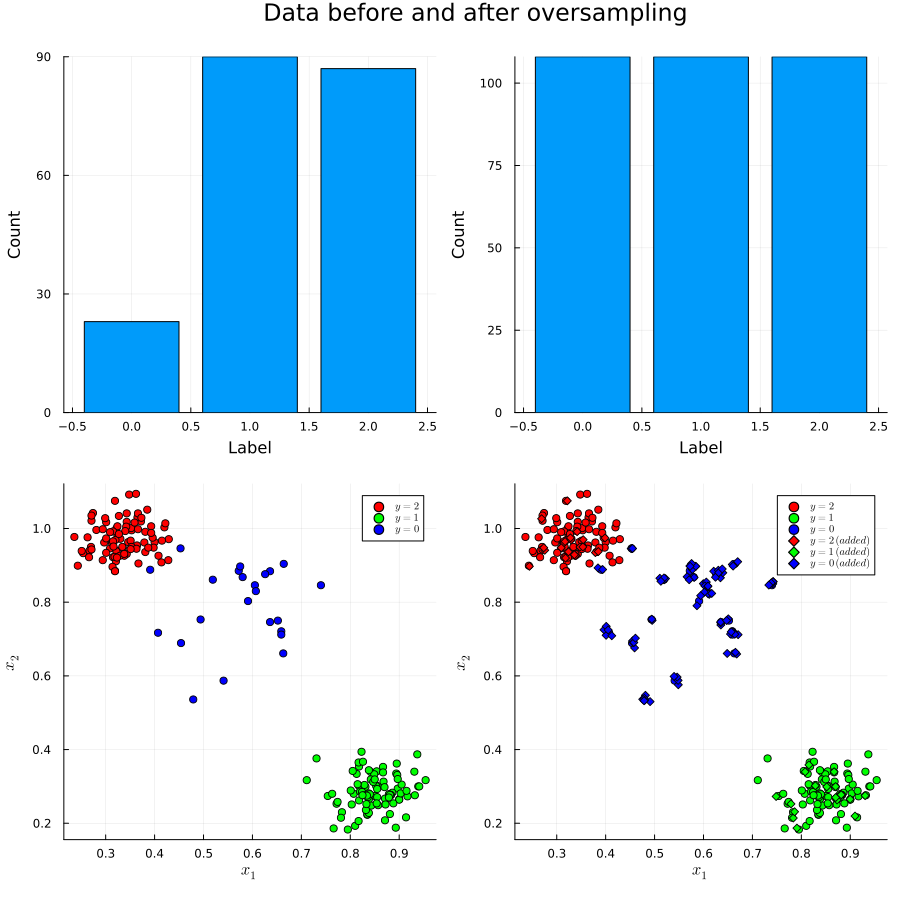

In [158]:
download("https://raw.githubusercontent.com/JuliaAI/Imbalance.jl/dev/examples/plot.jl", "./")
include("plot.jl")                      # provides a plot function to compare results
plot_data(y, yover, X, Xover)

Plots.AnimatedGif("/Users/essam/Documents/GitHub/Imbalance.jl/examples/assets/rose.gif")
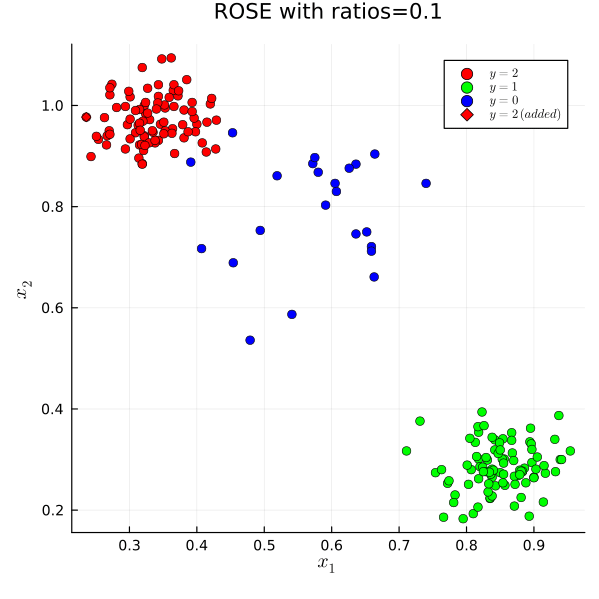

In [169]:
import Logging
Logging.disable_logging(Logging.Warn)

anim = @animate for ratios ∈ 0.1:0.02:1.2
	X_under, y_under = rose(X, y; ratios = ratios, rng = Random.Xoshiro(42))
	plot_data(y, y_under, X, X_under; single_plot=true, 
			  single_plot_title="ROSE with ratios=$ratios")
end
gif(anim, (isdir("./assets")) ? "./assets/rose.gif" : "./rose.gif", fps=3)